Inferred details about averaged hydro
--

`Mesh2_face_edges` 
 - is 0-based
 
`Mesh2_face_bottom_layer`
 - Stored 1-based
 - first layer above the bed.
 
`Mesh2_face_top_layer`
 - Stored 1-based
 - instantaneous at end of interval
 - last wet layer (highest in water column)
 - dry cells have Mesh2_face_top_layer==Mesh2_face_bottom_layer (indistinguishable from single layer. Have to consult water volume)
 - Consistent with Mesh2_face_water_volume

`Mesh2_edge_top_layer` 
 - Dry edges (edge_wet_area) *typically* have this set to 0, but in a few cases have this set to Mesh2_edge_bottom_layer.
 - an **instantaneous** value at the end of the interval. As such, limited usefulness since there can be (and are) nonzero flows above it.
 - In the PTM it is loaded into `side_new(j) % kt_edge`
 - Used immediately to copy u/v from lower edge to a thin (<dzmin) surface edge.
 - it's possible to have flow above kt_edge (since kt_edge is an instantaneous quantity and h_flow_avg is averaged), but FISH_PTM_hydrodynamics.f90:read_record_nc ignores any h_flow_avg above kt_edge
 - 

`Mesh2_edge_bottom_layer`
 - PTM forces this to >=1

`Mesh2_face_wet_area`
 - Interval averaged flux face area for vertical velocity
 
 
Potential issues with suntans output:
 - dzmin means that volume never goes to zero.  Appears to have min of dz=0.2mm.  Will this allow particles to diffuse onto dry land? How does the PTM determine whether an edge is wet for diffusion? This should be fine (notes below)
 - will need to think through how best to deal with fluxes above etop. (or adjust etop).
 - face_area should probably be zero'd out to match how untrim does things.
 - edge_area isn't the proper average, but instead based on instantaneous values.  that is probably going to be an issue.


**dzmin**

How is it enforced, and exactly which dzmin does 0.2mm correspond to?  This is the "CLAMPHEIGHT".  DRYCELLHEIGHT is set to 1mm.  if edge_wet_area is used reasonably, then edges with a dz below some threshold *and* zero flux could get there wet_area zero'd out (and etop=ebed or 0)

**PTM horizontal dispersion**

`update_i_side_crossing` is where bounces happen.  The check for a bounce during diffusion without
subgrid is `pt%z<-wc_int(i_new)%depth_cen`, in which case particle is bounced. This is probably okay -- cells that are dry but have their eta propped up a bit will still have their bed above the eta of a wet neighbor cell, and force a bounce.

**face_wet_area**

    Read into `v_face_area_avg`. Copied to wc_new(i)%area(k). used to get w, and nothing else. so no need to clean it up.
    
**plan:** 
etop and edge wet area must be consistent. in suntans code they are both calculated from instantaneous eta, so should be consistent. while that staggering is not ideal, it should mean that etop is at least as high as ctop elevation-wise.

any h_flow_avg above etop should be added to h_flow_avg below ctop. any edge with flow but no area generates an exception for now. may recalc dzf using eta_avg in the future.



In [44]:
import xarray as xr
from stompy import utils
from stompy.grid import unstructured_grid
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [410]:
nc.close()

In [477]:
# Continuity for a fully wet cell

try:
    nc.close()
except NamError:
    pass

try:
    nc_sun.close()
except NameError:
    pass
    
if 0: # reasonable wet cell for suntans runs
    n=3 # timestep.  Will test the interval with instantaneous outputs at n,n+1
    i=0 # cell
    k=35 # layer. 0-based from bed.
    k_partial=40
    nc=xr.open_dataset('/opt2/san_joaquin/cfg008/cfg008_20180320/ptm2_average.nc_0000.nc',
                       decode_cf=False)

if 0: # reasonable wet cell for suntans runs
    n=50 # timestep.
    i=0 # cell
    k=56 # layer. 0-based from bed.
    k_partial=40
    nc=xr.open_dataset('/opt2/sfb_ocean/suntans/runs/merged_021_20170610/ptm_average.nc_0000.nc',
                       decode_cf=False)
    
    nc_sun=xr.open_dataset('/opt2/sfb_ocean/suntans/runs/merged_021_20170610/average.nc_0000.nc')
    nc_sun=nc_sun.rename_vars(Nk='Nkc')


if 1: # untrim
    nc=xr.open_dataset('/home/rusty/tmp_untrim/untrim_hydro_Jan2017.nc',decode_cf=False)
    n=453 # timestep.  Will test the interval with instantaneous outputs at n,n+1
    i=2 # cell
    k=49 # layer. 0-based from bed.
    k_partial=52

In [478]:
print("nlayers: ",nc.dims['nMesh2_layer_3d'])
z_w=nc['Mesh2_layer_3d'].values
print(f"{len(z_w)} items in z_w  {z_w[:5]} ... {z_w[-5:]}")

print("Max cell depth: ",nc.Mesh2_face_depth.values.max())

nlayers:  54
54 items in z_w  [300.  281.8 256.1 232.9 211.7] ... [ 1.          0.         -1.         -2.          0.49999875]
Max cell depth:  18.0405


In [479]:
edge_nodes=nc['Mesh2_edge_nodes'].values
node_xy= np.c_[ nc['Mesh2_node_x'].values, nc['Mesh2_node_y'].values ]
edge_seg=node_xy[edge_nodes[:,1]] - node_xy[edge_nodes[:,0]]
edge_length=utils.dist(edge_seg)
edge_length ;

In [480]:
# Change in volume:
vols=nc.Mesh2_face_water_volume.isel(nMesh2_face=i,nMesh2_data_time=[n,n+1],nMesh2_layer_3d=k).values
print(f"[n={n} i={i} k={k}] volume change: {vols[0]} to {vols[1]},  delta={vols[1]-vols[0]}")

# Horizontal fluxes over that time step:
#js=nc.Mesh2_face_edges.isel(nMesh2_face=i).values.astype(np.int32)
#js=js[js>=0]

## Check that Mesh2_face_edges is 0-based:
face_edges=nc.Mesh2_face_edges.values.astype(np.int32)

if face_edges.min()<0:
    # I think that anything negative is okay
    print("INFO: missing face_edge value is ",face_edges.min())
elif face_edges.max()>nc.dims['nMesh2_edge']:
    print("WARNING: missing face_edge value is ",face_edges.max())
    
# assume that missing value is <0
face_edge_min=face_edges[face_edges>=0].min()
face_edge_max=face_edges[face_edges>=0].max()

if (face_edge_min==0) and (face_edge_max<nc.dims['nMesh2_edge']):
    print("INFO: Verified 0-based Mesh2_face_edges")
elif (face_edge_min>0) and (face_edge_max==nc.dims['nMesh2_edge']):
    print("WARNING: Verified 1-based Mesh2_face_edges")
elif (face_edge_min>0) and (face_edge_max<nc.dims['nMesh2_edge']):
    print("WARNING: Inconclusive 0/1-based Mesh2_face_edges")
else:
    print("ERROR: Mesh2_face_edges is not self-consistent, or bad missing value")

# Change in volume:
vols=nc.Mesh2_face_water_volume.isel(nMesh2_face=i,nMesh2_data_time=[n,n+1],nMesh2_layer_3d=k_partial).values
print(f"[n={n} i={i} k={k_partial}] volume change: {vols[0]} to {vols[1]},  delta={vols[1]-vols[0]}")

[n=453 i=2 k=49] volume change: 3464.5778 to 3464.5778,  delta=0.0
INFO: missing face_edge value is  -999
INFO: Verified 0-based Mesh2_face_edges
[n=453 i=2 k=52] volume change: 3285.578041653689 to 3137.7369943569156,  delta=-147.84104729677347


In [481]:
# Verify that ctop and water_volume are always consistent, and that
# ctop and cbot are both inclusive, stored as 1-based.

def check_cell_instantaneous(n=3):
    print(f"INFO: Time step {n}")
    kti=nc['Mesh2_face_top_layer'].isel(nMesh2_data_time=n).values
    kbi=nc['Mesh2_face_bottom_layer'].isel(nMesh2_data_time=n).values
    vol=nc['Mesh2_face_water_volume'].isel(nMesh2_data_time=n).values

    eta=nc['Mesh2_sea_surface_elevation'].isel(nMesh2_data_time=n).values
    depth=nc['Mesh2_face_depth'].values
    
    
    # last value is bogus, the rest give interface depths
    z_w=nc['Mesh2_layer_3d'].values[:-1]
    # so if eta would be inserted at 0, there is 1 layer and
    kti_calc=np.searchsorted(-z_w,eta)+1
    print(f"INFO: {(kti==kti_calc).sum()} of {len(kti)} match calc")
    above=(kti>kti_calc).sum()
    if above:
        # hmm - untrim shows this happening on occasion
        print(f"WARNING: {above} of {len(kti)} above kti_calc")
    below=kti<kti_calc
    print(f"INFO: {below.sum()} of {len(kti)} below calc")
    if np.any(below):
        dz_lump=eta[below] - -z_w[kti_calc[below]-2]
        print(f"INFO: dz lump in [{dz_lump.min():.5f},{dz_lump.max():.5f}]")

    # from the untrim code, this is actually a step-integrated value
    # face_areas=nc['Mesh2_face_wet_area'].isel(nMesh2_data_time=n).values

    # vol=np.ma.filled(vol,0.0)

    if np.any(kbi>kti):
        print("WARNING: kti not always >= kbi")

    if np.any(kbi<1):
        print("WARNING: kbi not always positive")

    if np.any(vol<0):
        print("WARNING: %d volumes are negative"%( (vol<0).sum() ))
        
        
    vol=nc['Mesh2_face_water_volume'].isel(nMesh2_data_time=n).values
    Ac=nc['Mesh2_face_wet_area'].isel(nMesh2_layer_3d=0,nMesh2_data_time=n).values
    min_V=vol.sum(axis=1).min()
    print("INFO: Min volume: ",min_V)
    print("INFO: Min dz:     ",(vol.sum(axis=1) / Ac.clip(1e-5)).min())

    dry_cells_negative_k=0
    dry_cells_single_empty_k=0
    wet_cells=0

    for i in utils.progress(range(len(kti))):
        # kbi inclusive, 1-based
        if kbi[i]<0:
            # dry - no, I think I was getting this b/c of nc3tonc4 weirdness.
            if kbi[i]!=kti[i]:
                print("WARNING: dry(?) cell has negative kbi, but kti(%d)!=kbi(%d)"%
                      (kti[i],kbi[i]))
            dry_cells_negative_k+=1
            continue
        if np.any( vol[i,:(kbi[i]-1)]!=0.0 ):
            print("WARNING: non-zero volumes below kbi")
        if np.any( vol[i,(kti[i]-1+1):] != 0.0 ):
            print("WARNING: non-zero volumes above kti")
        wet_vols=vol[i,kbi[i]-1:kti[i]-1+1]
        if np.any( wet_vols==0.0 ):
            dz=eta[i] + depth[i] # this comes up nonzero but vol is 0.0?

            # Is this a subgrid thing?
            if np.abs(dz)>1e-10:
                print("WARNING: zero volumes within i=%d  kbi=%d:kti=%d.  dz=%f"%(i,kbi[i],kti[i],dz))
                # since code suggest face_areas is step-integrated, don't look at it here.
                # print("         face_areas:",face_areas[i,:])
            if np.all(wet_vols==0):
                if len(wet_vols)==1: 
                    dry_cells_single_empty_k+=1
                else:
                    print("WARNING: empty water column with %d layers in kb:kt"%(len(wet_vols)))
        else:
            wet_cells+=1

    if dry_cells_negative_k>0:
        print(f"WARNING: dry_cells_negative_k:     {dry_cells_negative_k}")
    print(f"INFO: dry_cells_single_empty_k: {dry_cells_single_empty_k}")
    print(f"INFO: wet_cells:                {wet_cells}")
    
for n in range(50,65):
    check_cell_instantaneous(n=n)

INFO: Time step 50
INFO: 39939 of 39947 match calc
INFO: 2 of 39947 below calc
INFO: dz lump in [0.00000,0.00028]
INFO: Min volume:  0.0
INFO: Min dz:      0.0
INFO: dry_cells_single_empty_k: 9120
INFO: wet_cells:                30827
INFO: Time step 51
INFO: 39940 of 39947 match calc
INFO: 1 of 39947 below calc
INFO: dz lump in [0.00034,0.00034]
INFO: Min volume:  0.0
INFO: Min dz:      0.0
INFO: dry_cells_single_empty_k: 9120
INFO: wet_cells:                30827
INFO: Time step 52
INFO: 39937 of 39947 match calc
INFO: 4 of 39947 below calc
INFO: dz lump in [0.00002,0.00077]
INFO: Min volume:  0.0
INFO: Min dz:      0.0
INFO: dry_cells_single_empty_k: 9118
INFO: wet_cells:                30829
INFO: Time step 53
INFO: 39937 of 39947 match calc
INFO: 4 of 39947 below calc
INFO: dz lump in [0.00051,0.00071]
INFO: Min volume:  0.0
INFO: Min dz:      0.0
INFO: dry_cells_single_empty_k: 9118
INFO: wet_cells:                30829
INFO: Time step 54
INFO: 39939 of 39947 match calc
INFO: 2 o

In [417]:
# reading through the untrim netcdf io code:
# face_wet_area is period averaged vertical conveyance area.
# From the netcdf attributes, Mesh2_edge_top_layer is actually
# instantaneous (it says at end of interval).
e2c=nc.Mesh2_edge_faces.values
face_bc=nc.Mesh2_face_bc.values

# Similar but for etop. Slightly more difficult since stagnant water harder to
# discern from empty space.
def check_edge_interval(n):
    print("INFO: checking edges at time interval",n)
    ktj=nc['Mesh2_edge_top_layer'].isel(nMesh2_data_time=n).values

    n_prev=max(0,n-1)
    ktj_prev=nc['Mesh2_edge_top_layer'].isel(nMesh2_data_time=n_prev).values
    

    kbj=nc['Mesh2_edge_bottom_layer'].isel(nMesh2_data_time=n).values
    Q=nc['h_flow_avg'].isel(nMesh2_data_time=n).values
    A=nc['Mesh2_edge_wet_area'].isel(nMesh2_data_time=n).values

    n_ktj_below_kbj=(ktj<kbj).sum()
    if n_ktj_below_kbj:
        # checked and these are not simply land boundaries.
        print(f'INFO: {n_ktj_below_kbj}/{len(ktj)} edge ktop below edge kbot')

    n_flow_above_ktj=0
    for j in utils.progress(range(len(ktj))):
        # kbi inclusive, 1-based
        if kbj[j]<0:
            # dry?
            if kbj[j]!=ktj[j]:
                print("WARNING: dry(?) edge has negative kbj, but ktj(%d)!=kbj(%d)"%
                      (ktj[j],kbj[j]))
            continue
        if np.any( Q[j,:(kbj[j]-1)]!=0.0 ):
            print("WARNING: non-zero flows below kbj")
            break
        above=slice( max(kbj[j],ktj[j])-1+1,None)
        if np.any( Q[j,above] != 0.0 ):
            # print("INFO: non-zero flows above ktj (ok b/c ktj is instantaneous)")
            n_flow_above_ktj+=1
            if np.sum(Q[j,above]!=0.0)>1:
                # not necessarily an error, bu pretty unlikely.
                print("WARNING: multiple layers above ktj have flow")
            # how thick is this edge?
            # print( f"flow above ktj has A={A[j,above][0]}, dz={A[j,above][0]/edge_length[j]}")
        Qwet=Q[j,kbj[j]-1:ktj[j]-1+1]
        Awet=A[j,kbj[j]-1:ktj[j]-1+1]
        if np.any( Awet==0.0 ):
            # Curious how this happens. 
            # It doesn't happen often -- so it could be edges that just got wet,
            # so the integrated A is zero, but instantaneously 
            #print("WARNING: zero h-flow area within kbj:ktj")
            pass

        if np.any( (A[j,:]==0.0) & (Q[j]!=0.0) ):
            print("WARNING: zero flux area and nonzero Q")

        # nuanced test for surface layer missing flow.
        # note that it's possible to have a zero-area, zero flow surface layer
        # (happens on occasion), so only check against layers with nonzero area.
        Qwetwet=Qwet[Awet>0.0]
        if (len(Qwetwet)>1) and (Qwetwet[-1]==0.0) and np.any(Qwetwet!=0.0):
            # This does happen in type3 (etaBC) cells, due to some weirdness in the
            # suntans output that pegs eta to 0.0. 
            if np.any(e2c[j,:]<0): 
                # don't worry about boundary edges
                pass
            elif np.any(face_bc[e2c[j,:]]==3):
                # type 3 cells are screwed up anyway
                pass
            else:
                print("WARNING: exactly zero flow overlaying nonzero flow within kbj:ktj")
                print(f"  j={j}")
                print( "   Qwet:",Qwet)
                print( "   edge dz:",Awet/edge_length[j])
                print(f"   kbj={kbj[j]}   ktj={ktj[j]}")
                return

    # Define dry edges as zero area
    dry_edges= (A.sum(axis=1)==0.0)
    n_dry_edges_ktj_0 = ( dry_edges & (ktj==0)).sum()
    n_dry_edges_ktj_kbj = (dry_edges & (ktj==kbj)).sum()
    n_dry_edges_bad = dry_edges.sum() - n_dry_edges_ktj_0 - n_dry_edges_ktj_kbj

    print(f"INFO: {n_dry_edges_ktj_0} / {dry_edges.sum()} dry edges have ktj==0")
    print(f"INFO: {n_dry_edges_ktj_kbj} / {dry_edges.sum()} dry edges have ktj==kbj")
    if n_dry_edges_bad:
        print(f"WARNING: {n_dry_edges_bad} had ktj not in 0,kbj")
    print(f"INFO: n_flow_above_ktj: {n_flow_above_ktj} / {len(ktj)}")
    

for n in range(5,6): #nc.dims['nMesh2_data_time']):
    check_edge_interval(n)


INFO: checking edges at time interval 5
  j=79982
   Qwet: [ 5.97790595e+04  3.11342472e+04  1.98454791e+04  8.35246118e+03
  7.09432281e+03  4.07086242e+03  3.84755409e+03  3.14781277e+03
  3.31261694e+03  3.83640224e+03  3.06201545e+03  3.55669218e+03
  2.61025327e+03  2.31488541e+03  1.81704774e+03  1.35512165e+03
  1.00904575e+03  8.85101333e+02  7.17329314e+02  7.46397788e+02
  6.81493664e+02  6.56533901e+02  6.62420878e+02  6.85511439e+02
  6.87832070e+02  6.94445767e+02  6.50146994e+02  5.06098337e+02
  4.99666025e+02  4.10609803e+02  3.51647200e+02  2.85060034e+02
  2.26895661e+02  1.76925677e+02  1.35159833e+02  9.06829867e+01
  3.68827387e+01  7.21113879e+00 -1.67054594e+01 -5.29380420e+01
 -1.18380006e+02 -2.11627089e+02 -2.55761292e+02 -3.81072992e+02
 -4.86822893e+02 -5.33756573e+02 -5.28887429e+02 -5.01687875e+02
 -4.66347988e+02 -4.28938575e+02 -3.92206622e+02 -3.57466547e+02
 -3.25279084e+02 -3.57462623e+02 -0.00000000e+00]
   edge dz: [4.57293201e+02 4.06482901e+02 3.6

In [447]:
ti=5
nct=nc.isel(nMesh2_data_time=ti)

j=79982
print("---- PTM ----")
eta=nct['Mesh2_sea_surface_elevation'].values
cdepth=nct['Mesh2_face_depth'].values
e2c=nct['Mesh2_edge_faces'].isel(nMesh2_edge=j).values
fbc=nct['Mesh2_face_bc'].values
print("j nbrs:",e2c)
print("  etas=",eta[e2c])
print("  depths=",cdepth[e2c])
print("  face_bc=",fbc[e2c])

z_w=nct['Mesh2_layer_3d'].values
print("z_w[-10:]",z_w[-10:])

ktj=nct['Mesh2_edge_top_layer'].isel(nMesh2_edge=j).item() # 55
ktis=nct['Mesh2_face_top_layer'].values[e2c] # 55,55
Q=nct['h_flow_avg'].isel(nMesh2_edge=j).values
print("Q[-10:]:",Q[-10:]) # this has 6 empty layers.

# so why did we not pick this up?
# these show nu_v empty just last 5 layers
nu_v=nct['Mesh2_vertical_diffusivity_3d'].values[e2c,-10:]
print("nu[-10:]",nu_v)

print("---- SUN ----")
ncs=nc_sun.isel(time=ti)

print("eta:",ncs.eta.values[e2c]) # match
print("z_w[:10]",ncs.z_w.values[:10]) # fine

# from eta, what should kti be?
# in suntans world w/o dzmin_surface, eta=-3.42 is
# above z_w[6]=-3.605599. so 0-based ctop=5, topmost
# valid layer.  ctop=0..4 is 5 empty layers.
# eta=-3.347 is the same
print("eta-0.25",eta[e2c]-0.25)
# with dzmin_surface nc1 is one layer down.
print("eta_avg-0.25",ncs.eta_avg.values[e2c]-0.25)
# both of the eta_avg are lower.
# possible that nu_v is picking up a newly wetted cell, w


---- PTM ----
j nbrs: [42544 42689]
  etas= [-3.42353762 -3.3472506 ]
  depths= [4112.129 4112.129]
  face_bc= [0 0]
z_w[-10:] [6.6213185 5.4956355 4.4950285 3.6055999 2.8149967 2.1122383 1.4875642
 0.9322983 0.4387286 0.       ]
Q[-10:]: [-392.20662236 -357.46654684 -325.27908401 -357.46262273   -0.
   -0.           -0.           -0.           -0.           -0.        ]
nu[-10:] [[0.01498248 0.01220352 0.00924649 0.00330417 0.00115199 0.
  0.         0.         0.         0.        ]
 [0.01524243 0.01243499 0.00912671 0.00229536 0.00069695 0.
  0.         0.         0.         0.        ]]
---- SUN ----
eta: [-3.42353762 -3.3472506 ]
z_w[:10] [0.        0.4387286 0.9322983 1.4875642 2.1122383 2.8149967 3.6055999
 4.4950285 5.4956355 6.6213185]
eta-0.25 [-3.67353762 -3.5972506 ]
eta_avg-0.25 [-3.65478949 -3.68206307]


In [ ]:
g=unstructured_grid.UnstructuredGrid.read_ugrid(nc,dialect='fishptm')

In [ ]:
plt.figure()
eta=nc['Mesh2_sea_surface_elevation'].isel(nMesh2_data_time=2)
face_bc=nc.Mesh2_face_bc.values

g.plot_edges(color='k',lw=0.5)
g.plot_edges(mask=[724],color='b',lw=2.5)
ccoll=g.plot_cells(values=eta,lw=0,cmap='jet')
plt.colorbar(ccoll)

ax=plt.gca()
ax.set_adjustable('datalim')
ax.axis('equal')

In [ ]:
nc_sun=xr.open_dataset('/opt2/san_joaquin/cfg008/cfg008_20180320/average.nc_0000.nc')
nc_sun=nc_sun.rename_vars(Nk='Nkc')


In [ ]:
nc_sun.time.values[:10]

In [375]:
model=sun_driver.SuntansModel.load('/opt2/sfb_ocean/suntans/runs/merged_021_20170610')

In [373]:
from stompy.model.suntans import sun_driver

In [377]:
# Take a look at sfb_ocean
#g=unstructured_grid.UnstructuredGrid.read_suntans('/opt2/sfb_ocean/suntans/runs/merged_021_20170610/')
#xr.open_dataset('/opt2/sfb_ocean/suntans/runs/merged_021_20170610/')
g=model.grid

<IPython.core.display.Javascript object>


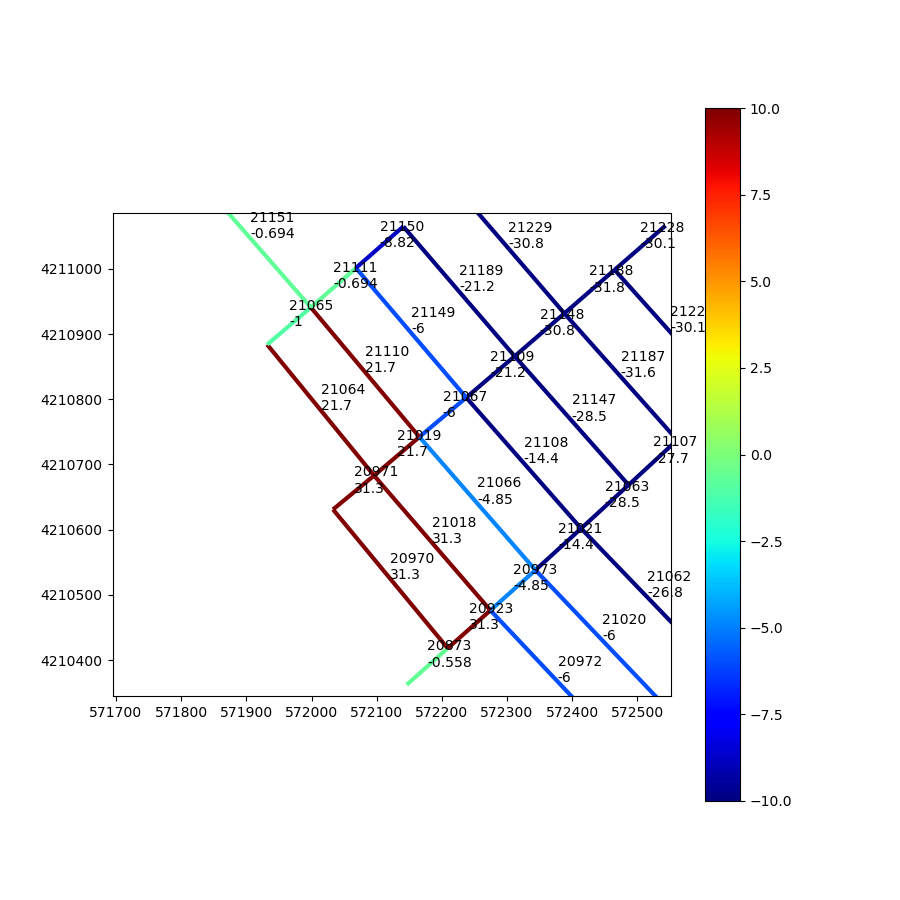

(571694.6570944983, 572550.8352666761, 4210344.866084911, 4211085.789503141)

In [397]:
fig,ax=plt.subplots(figsize=(9,9))

#zoom=(570412.6974972951, 573981.2858149259, 4209386.687285769, 4212474.888714488)
zoom=(571694.6570944983, 572550.8352666761, 4210344.866084911, 4211085.789503141)

ecoll=g.plot_edges(values=g.edges['edge_z_bed'],lw=3,ax=ax,cmap='jet',
                   labeler=lambda i,rec: "%d\n%.3g"%(i,rec['edge_z_bed']),
                   clip=zoom)
#g.plot_edges(mask=[21019],lw=2.7,color='r',ax=ax)
ecoll.set_clim([-10,10])
plt.colorbar(ecoll)

#ccoll=g.plot_cells(values=g.cells['z_bed'],ax=ax,cmap='jet',lw=0)
#ccoll.set_clim([-10,10])
ax.axis(zoom)

Replicating Continuity Check in FISH-PTM
--


In [18]:
nc=xr.open_dataset('runs/cfg012_farm12_20180310/ptm_average.nc_0000.nc',
                   decode_cf=True)

import six
six.moves.reload_module(unstructured_grid)

g=unstructured_grid.UnstructuredGrid.read_ugrid(nc)

First, revisit the edge ordering

In [121]:
face_edges=nc['Mesh2_face_edges'].values

for c in range(g.Ncells()):
    calc_edges=np.array( g.cell_to_edges(c,ordered=True) )
    nsides=len(calc_edges)
    from_nc=face_edges[c]
    from_nc=from_nc[from_nc>=0]
    cell_nbrs=np.array( g.cell_to_cells(c,ordered=True) )
    internal_edges=cell_nbrs>=0
    assert np.all( (calc_edges==from_nc)[internal_edges] )

In [115]:
g.cells['nodes'][c] # Confirms that the nodes are the identical, incl. order

array([ 261, 6589,  882, 2799], dtype=int32)

In [114]:
g.cells_center()[c] # confirms that these are the same cell.

array([ 646968.92235, 4185776.616  ])

In [118]:
g.cell_to_cells(c,ordered=True) # Okay - so the issue creeps in when
# cells are missing.  suntans only requires input of the 

[1180, 1161, -1, -1]

In [119]:
calc_edges, from_nc

(array([4781, 4711, 4678, 3206], dtype=int32),
 array([4781, 4711, 3206, 4678], dtype=int32))

In [ ]:
# How did that happen?  Should have been in the correct order...
# Looking at the inputs for suntans, line cells.dat:1187
# 4 6.469689223471e+05 4.185776616006e+06 261 6589 882 2799 1180 1161 -1 -1 


<IPython.core.display.Javascript object>


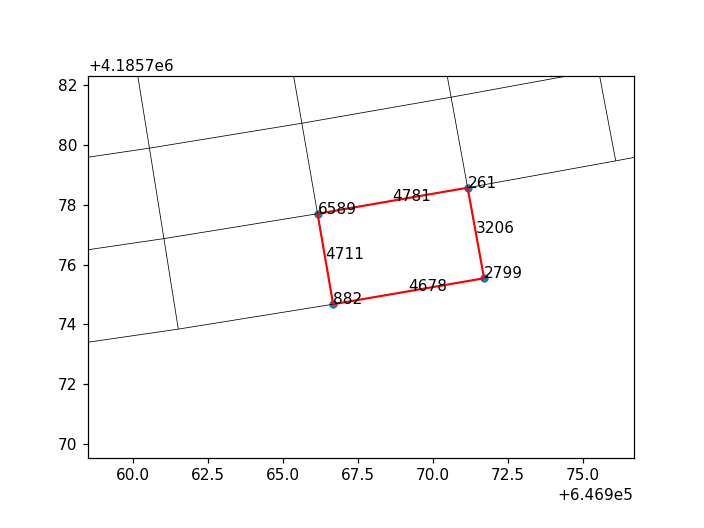

In [112]:
plt.figure()
g.plot_edges(color='k',lw=0.5)
g.plot_edges(mask=calc_edges,color='r',lw=1.4,labeler='id')
g.plot_nodes(mask=g.cell_to_nodes(c),labeler='id')

In [132]:

time_var='Mesh2_data_time'
time_dim='nMesh2_data_time'
vol_var='Mesh2_face_water_volume'

kbi_var='Mesh2_face_bottom_layer'
kti_var='Mesh2_face_top_layer'
kbj_var='Mesh2_edge_bottom_layer'
ktj_var='Mesh2_edge_top_layer'
h_flow_var='h_flow_avg'
face_depth_var='Mesh2_face_depth'
face_eta_var='Mesh2_sea_surface_elevation'
face_mark_var='Mesh2_face_bc'
Nkmax=nc.dims['nMesh2_layer_3d']

layer_continuity=[]
cell_continuity=[]

for n in range(5,55):
    # continuity check
    n_new=n
    n_old=n-1

    time_new=nc[time_var].values[n_new]
    time_old=nc[time_var].values[n_old]
    dt_step = (time_new - time_old) / np.timedelta64(1,'s') # convert to seconds

    print("Checking continuity from step %d to %d (%s)"%(n_old,n_new,time_new))
    
    # Note these are all 1-based, and inclusive at both ends.
    kbi_old=nc[kbi_var].isel(**{time_dim:n_old}).values 
    kti_old=nc[kti_var].isel(**{time_dim:n_old}).values
    kbj_old=nc[kbj_var].isel(**{time_dim:n_old}).values
    ktj_old=nc[ktj_var].isel(**{time_dim:n_old}).values 

    kbi_new=nc[kbi_var].isel(**{time_dim:n_new}).values
    kti_new=nc[kti_var].isel(**{time_dim:n_new}).values
    kbj_new=nc[kbj_var].isel(**{time_dim:n_new}).values
    ktj_new=nc[ktj_var].isel(**{time_dim:n_new}).values

    vol_old=nc[vol_var].isel(**{time_dim:n_old}).values
    vol_new=nc[vol_var].isel(**{time_dim:n_new}).values

    # Here -- may need to double check interpretation of the time staggering.
    h_flow=nc[h_flow_var].isel(**{time_dim:n_new}).values

    depth_i=nc[face_depth_var].values
    face_bc=nc[face_mark_var].values
    eta_old=nc[face_eta_var].isel(**{time_dim:n_old}).values
    eta_new=nc[face_eta_var].isel(**{time_dim:n_new}).values

    for i_loop in utils.progress(range(g.Ncells())):
        volume_check = 0. # volume
        volume_i_old = 0.
        volume_i_new = 0.
        kb_min = min(kbi_old[i_loop], kbi_new[i_loop])
        kb_max = max(kbi_old[i_loop], kbi_new[i_loop])
        kt_min = min(kti_old[i_loop], kti_new[i_loop])
        kt_max = max(kti_old[i_loop], kti_new[i_loop])

        kt_max=Nkmax # To check for high-layer fluxes. 
    
        # kt is inclusive, but range is exclusive of the end, so increment by 1,
        # kb_min and kt_max are 1-based, so subtract 1 from both
        for k in range(kb_min-1, kt_max+1-1):
            volume_k_old = vol_old[i_loop,k] #  dz(k) * polygon_area(i_loop)
            volume_k_new = vol_new[i_loop,k] #  dz(k) * polygon_area(i_loop)
            volume_check_k = volume_k_old
            volume_i_old = volume_i_old + volume_k_old
            volume_i_new = volume_i_new + volume_k_new
            volume_check = volume_check + volume_k_old
            for nside in range(g.cell_Nsides(i_loop)): # 1, polygon_nsides(i_loop)
                j = g.cells['edges'][i_loop,nside] # polygon_side(i_loop,nside)
                # need to calculate sign of flow at side!
                #u_k = side_new(j) % u(k)
                #v_k = side_new(j) % v(k)
                #CALL calculate_normal_vel_to_side(j, u_k, v_k, i_loop, u_out,"cc")
                #outflow_side = u_out*side_new(j) % dz(k)*side_length(j)
                if g.edges['cells'][j,0]==i_loop:
                    sign=1.0
                elif g.edges['cells'][j,1]==i_loop:
                    sign=-1.0
                else:
                    raise Exception('Cell %d not found for edge %d'%(i_loop,j))
                outflow_side=sign*h_flow[j,k] 
                volume_check = volume_check - outflow_side*dt_step
                volume_check_k = volume_check_k - outflow_side*dt_step
            # Note that the k volume check ignores vertical fluxes, so don't worry about
            # logging it.
        error = volume_check-volume_i_new
        percent_error = 100.*(volume_check-volume_i_new)/volume_i_new
        depth_total_new = depth_i[i_loop] + eta_new[i_loop]
        depth_total_old = depth_i[i_loop] + eta_old[i_loop]
        cell_continuity.append( dict(cell=i_loop,
                                     n_new=n_new,
                                     face_bc=face_bc[i_loop],
                                     depth_old=depth_total_old,depth_new=depth_total_new,
                                     vol_old=volume_i_old,
                                     vol_new=volume_i_new, vol_check=volume_check, error=error,
                                     pct_error=percent_error))


Checking continuity from step 4 to 5 (2018-03-10T02:30:00.000000000)


INFO:utils:3010/11191
INFO:utils:7918/11191


Checking continuity from step 5 to 6 (2018-03-10T03:00:00.000000000)


INFO:utils:3065/11191
INFO:utils:7966/11191


Checking continuity from step 6 to 7 (2018-03-10T03:30:00.000000000)


INFO:utils:2697/11191
INFO:utils:7225/11191
INFO:utils:10390/11191


Checking continuity from step 7 to 8 (2018-03-10T04:00:00.000000000)


INFO:utils:3066/11191
INFO:utils:7977/11191


Checking continuity from step 8 to 9 (2018-03-10T04:30:00.000000000)


INFO:utils:2930/11191
INFO:utils:7524/11191
INFO:utils:10700/11191


Checking continuity from step 9 to 10 (2018-03-10T05:00:00.000000000)


INFO:utils:2914/11191
INFO:utils:7489/11191
INFO:utils:10923/11191


Checking continuity from step 10 to 11 (2018-03-10T05:30:00.000000000)


INFO:utils:3080/11191
INFO:utils:7981/11191


Checking continuity from step 11 to 12 (2018-03-10T06:00:00.000000000)


INFO:utils:2805/11191
INFO:utils:7252/11191
INFO:utils:10505/11191


Checking continuity from step 12 to 13 (2018-03-10T06:30:00.000000000)


INFO:utils:2752/11191
INFO:utils:7482/11191
INFO:utils:10913/11191


Checking continuity from step 13 to 14 (2018-03-10T07:00:00.000000000)


INFO:utils:3053/11191
INFO:utils:7907/11191
INFO:utils:11121/11191


Checking continuity from step 14 to 15 (2018-03-10T07:30:00.000000000)


INFO:utils:2758/11191
INFO:utils:7185/11191
INFO:utils:10333/11191


Checking continuity from step 15 to 16 (2018-03-10T08:00:00.000000000)


INFO:utils:2835/11191
INFO:utils:7268/11191
INFO:utils:10519/11191


Checking continuity from step 16 to 17 (2018-03-10T08:30:00.000000000)


INFO:utils:2864/11191
INFO:utils:7363/11191
INFO:utils:10583/11191


Checking continuity from step 17 to 18 (2018-03-10T09:00:00.000000000)


INFO:utils:2949/11191
INFO:utils:7786/11191
INFO:utils:11131/11191


Checking continuity from step 18 to 19 (2018-03-10T09:30:00.000000000)


INFO:utils:2895/11191
INFO:utils:7408/11191
INFO:utils:10555/11191


Checking continuity from step 19 to 20 (2018-03-10T10:00:00.000000000)


INFO:utils:2967/11191
INFO:utils:7572/11191
INFO:utils:10851/11191


Checking continuity from step 20 to 21 (2018-03-10T10:30:00.000000000)


INFO:utils:2929/11191
INFO:utils:7504/11191
INFO:utils:10922/11191


Checking continuity from step 21 to 22 (2018-03-10T11:00:00.000000000)


INFO:utils:3113/11191
INFO:utils:7997/11191


Checking continuity from step 22 to 23 (2018-03-10T11:30:00.000000000)


INFO:utils:2797/11191
INFO:utils:7441/11191
INFO:utils:10519/11191


Checking continuity from step 23 to 24 (2018-03-10T12:00:00.000000000)


INFO:utils:2893/11191
INFO:utils:7576/11191
INFO:utils:11061/11191


Checking continuity from step 24 to 25 (2018-03-10T12:30:00.000000000)


INFO:utils:3079/11191
INFO:utils:7722/11191
INFO:utils:10675/11191


Checking continuity from step 25 to 26 (2018-03-10T13:00:00.000000000)


INFO:utils:2919/11191
INFO:utils:7428/11191
INFO:utils:10606/11191


Checking continuity from step 26 to 27 (2018-03-10T13:30:00.000000000)


INFO:utils:3080/11191
INFO:utils:7957/11191


Checking continuity from step 27 to 28 (2018-03-10T14:00:00.000000000)


INFO:utils:2906/11191
INFO:utils:7500/11191
INFO:utils:10691/11191


Checking continuity from step 28 to 29 (2018-03-10T14:30:00.000000000)


INFO:utils:2871/11191
INFO:utils:7590/11191
INFO:utils:11094/11191


Checking continuity from step 29 to 30 (2018-03-10T15:00:00.000000000)


INFO:utils:3063/11191
INFO:utils:7834/11191
INFO:utils:11052/11191


Checking continuity from step 30 to 31 (2018-03-10T15:30:00.000000000)


INFO:utils:2914/11191
INFO:utils:7512/11191
INFO:utils:10773/11191


Checking continuity from step 31 to 32 (2018-03-10T16:00:00.000000000)


INFO:utils:2895/11191
INFO:utils:7656/11191
INFO:utils:11147/11191


Checking continuity from step 32 to 33 (2018-03-10T16:30:00.000000000)


INFO:utils:2975/11191
INFO:utils:7565/11191
INFO:utils:10691/11191


Checking continuity from step 33 to 34 (2018-03-10T17:00:00.000000000)


INFO:utils:2805/11191
INFO:utils:7455/11191
INFO:utils:10804/11191


Checking continuity from step 34 to 35 (2018-03-10T17:30:00.000000000)


INFO:utils:3017/11191
INFO:utils:7791/11191
INFO:utils:10947/11191


Checking continuity from step 35 to 36 (2018-03-10T18:00:00.000000000)


INFO:utils:2824/11191
INFO:utils:7370/11191
INFO:utils:10563/11191


Checking continuity from step 36 to 37 (2018-03-10T18:30:00.000000000)


INFO:utils:2944/11191
INFO:utils:7794/11191


Checking continuity from step 37 to 38 (2018-03-10T19:00:00.000000000)


INFO:utils:2976/11191
INFO:utils:7543/11191
INFO:utils:10955/11191


Checking continuity from step 38 to 39 (2018-03-10T19:30:00.000000000)


INFO:utils:2907/11191
INFO:utils:7370/11191
INFO:utils:10552/11191


Checking continuity from step 39 to 40 (2018-03-10T20:00:00.000000000)


INFO:utils:2908/11191
INFO:utils:7610/11191
INFO:utils:10856/11191


Checking continuity from step 40 to 41 (2018-03-10T20:30:00.000000000)


INFO:utils:2996/11191
INFO:utils:7844/11191


Checking continuity from step 41 to 42 (2018-03-10T21:00:00.000000000)


INFO:utils:3035/11191
INFO:utils:7590/11191
INFO:utils:10909/11191


Checking continuity from step 42 to 43 (2018-03-10T21:30:00.000000000)


INFO:utils:2896/11191
INFO:utils:7408/11191
INFO:utils:10627/11191


Checking continuity from step 43 to 44 (2018-03-10T22:00:00.000000000)


INFO:utils:2826/11191
INFO:utils:7576/11191
INFO:utils:10898/11191


Checking continuity from step 44 to 45 (2018-03-10T22:30:00.000000000)


INFO:utils:3058/11191
INFO:utils:7947/11191


Checking continuity from step 45 to 46 (2018-03-10T23:00:00.000000000)


INFO:utils:2890/11191
INFO:utils:7251/11191
INFO:utils:10444/11191


Checking continuity from step 46 to 47 (2018-03-10T23:30:00.000000000)


INFO:utils:2887/11191
INFO:utils:7382/11191
INFO:utils:10619/11191


Checking continuity from step 47 to 48 (2018-03-11T00:00:00.000000000)


INFO:utils:2924/11191
INFO:utils:7465/11191
INFO:utils:10918/11191


Checking continuity from step 48 to 49 (2018-03-11T00:30:00.000000000)


INFO:utils:3034/11191
INFO:utils:7891/11191


Checking continuity from step 49 to 50 (2018-03-11T01:00:00.000000000)


INFO:utils:2920/11191
INFO:utils:7454/11191
INFO:utils:10641/11191


Checking continuity from step 50 to 51 (2018-03-11T01:30:00.000000000)


INFO:utils:2914/11191
INFO:utils:7435/11191
INFO:utils:10603/11191


Checking continuity from step 51 to 52 (2018-03-11T02:00:00.000000000)


INFO:utils:2883/11191
INFO:utils:7477/11191
INFO:utils:10689/11191


Checking continuity from step 52 to 53 (2018-03-11T02:30:00.000000000)


INFO:utils:3030/11191
INFO:utils:7917/11191


Checking continuity from step 53 to 54 (2018-03-11T03:00:00.000000000)


INFO:utils:2794/11191
INFO:utils:7308/11191
INFO:utils:10387/11191


In [133]:
# layer_df=pd.DataFrame(layer_continuity)
cell_df=pd.DataFrame(cell_continuity)

In [134]:
cell_df.head()

,cell,n_new,face_bc,depth_old,depth_new,vol_old,vol_new,vol_check,error,pct_error
0,0,5,0,0.000200,0.000200,0.003591,0.003591,0.003591,0.000000,0.000000
1,1,5,0,0.000200,0.000200,0.003812,0.003812,0.003812,0.000000,0.000000
2,2,5,0,2.609275,2.566729,52.687687,51.828576,51.825731,-0.002845,-0.005490
3,3,5,0,0.000200,0.000200,0.002874,0.002874,0.002874,0.000000,0.000000
4,4,5,0,2.333334,2.290702,45.331827,44.503584,44.501630,-0.001954,-0.004392


In [135]:
bad_pct=abs(cell_df.pct_error.values)> 1.0
non_bc=cell_df.face_bc.values!=3

bad_cells=cell_df[ bad_pct & non_bc ]
print("%d cells with worse than 1%% error"%len(bad_cells))
bad_cells

1027 cells with worse than 1% error


,cell,n_new,face_bc,depth_old,depth_new,vol_old,vol_new,vol_check,error,pct_error
13549,2358,6,0,0.090894,0.049982,1.290395,0.709580,0.720014,0.010434,1.470401
22217,11026,6,0,0.090203,0.050541,1.022083,0.572672,0.582827,0.010155,1.773236
22295,11104,6,0,0.364218,0.323190,3.785582,3.359153,3.452656,0.093503,2.783525
22327,11136,6,0,0.089523,0.049962,0.389974,0.217641,0.263153,0.045512,20.911552
25053,2671,7,0,0.065616,0.049972,0.840319,0.639975,0.695907,0.055932,8.739743
...,...,...,...,...,...,...,...,...,...,...
552980,4621,54,0,0.000200,0.050163,0.001708,0.428365,0.691439,0.263074,61.413394
552981,4622,54,0,0.049942,0.049992,0.429781,0.430207,3.956195,3.525988,819.603063
552982,4623,54,0,0.000200,0.050486,0.001781,0.449469,0.660013,0.210543,46.842645
552983,4624,54,0,0.000200,0.049895,0.001791,0.446713,0.194682,-0.252030,-56.418893


<IPython.core.display.Javascript object>


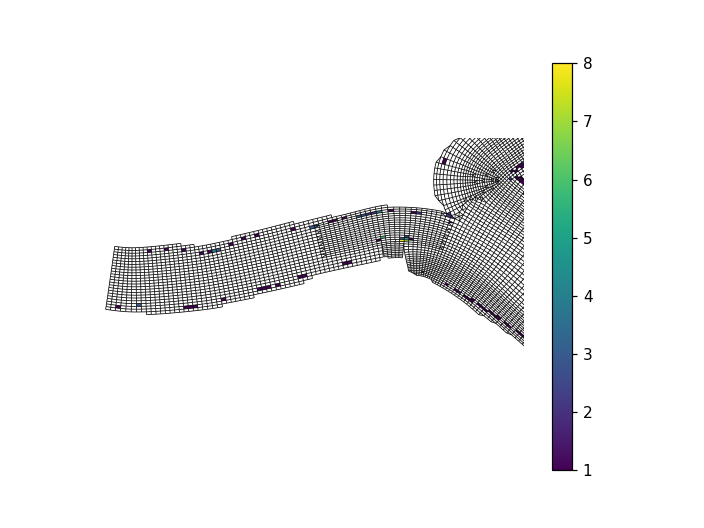

(646848.34449, 648043.89549, 4185468.6746, 4186172.4437)

In [136]:
cell_and_count=bad_cells.groupby('cell').size()

plt.figure()
g.plot_edges(color='k',lw=0.5)
ccoll=g.plot_cells(mask=cell_and_count.index.values,values=cell_and_count.values)
plt.colorbar(ccoll)
plt.axis('off')

For time step n=50, there were 27 cells with worse than 1% error.
Of those, 7 had bad errors due to the volumes being small, and the
actual error was on the order of 0.01 m$^3$.

If I integrate flows all the way to the surface, I still get 27 
cells that fail.

21 of the bad cells are at the HOR boundary, where there is a freesurface
boundary condition.

Checking over 50 time steps, there are a total of 1183 offenses that are
not BC=3 cells.  Most of the cells are at the wetting drying front, but
a small number occur in a band across the channel.

If I integrate all of the flows, the number of problems goes from 1183
to 1027.  Plotting that up, the remaining problem cells are all at the
wetting/drying front.

<IPython.core.display.Javascript object>


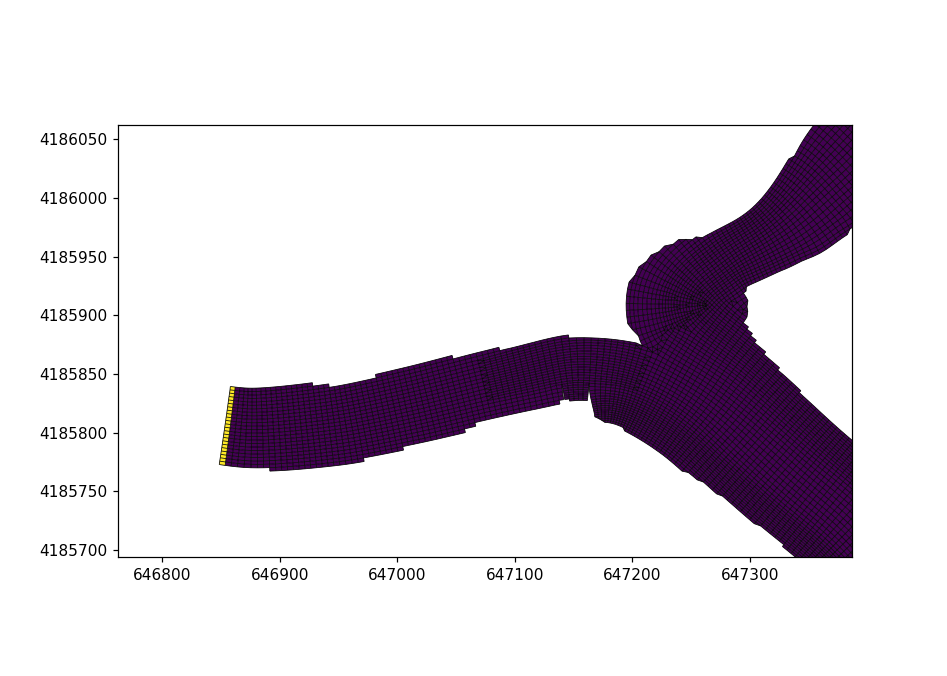

In [97]:
plt.figure()
g.plot_edges(color='k',lw=0.5)
#g.plot_cells(mask=bad_cells['cell'].values)
g.plot_cells(values=nc['Mesh2_face_bc'].values)

In [96]:
nc['Mesh2_face_bc'].max

<xarray.DataArray 'Mesh2_face_bc' ()>
array(3, dtype=int32)